In [1]:
#주파수 도메인에서 전자기장을 나타내는 데이터를 저장하고 처리하는데 사용됩니다. 공간 도메인에서 시간 도메인으로 전자기장을 변환하는 푸리에 변환을 수행
#전자기파 시뮬레이션 결과를 주파수 도메인으로 변환하여 저장합니다. 전자기장의 크기와 위상 정보

Defining mpa.FourierFields is similar to define mpa.EigenmodeCoefficient, but we pass a component of interest intead of mode number. We can define several components, and let the objective be a function of them simultaneously.

The first axis of the value returned by Fourier Fields corresponds to the index of frequency; the rest has the dimensions of the monitor. In this case, it is 1D, so we simply provide the index of point at which we would like to optimize the fields.

The objective function can involve several fields component, at several frequencies, and involve several points. Since we specify the points by indices, it is probably more common to have an objective as an average/sum of values at all points, where we don't need specific indices and just use `:` instead.

Also note that the optimization problem includes a wider frequency spectrum, but the particular objective defined below depends on one frequency only. Alternatively, we can define a single frequency from the start.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt

mp.verbosity(0)
seed = 240
np.random.seed(seed)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

In [2]:
resolution = 20

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(1.0)]

In [3]:
fcen = 1 / 1.15
width = 0.1
fwidth = width * fcen
source_center = [-1, 0, 0]
source_size = mp.Vector3(0, 2, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

In [4]:
design_region_resolution = 10
Nx = design_region_resolution + 1
Ny = design_region_resolution + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables, volume=mp.Volume(
        
        center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
)


geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx/2, 0.5, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(y=Sy / 4), material=Si, size=mp.Vector3(0.5, Sy / 2, 0)
    ),  # vertical waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
    # mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
    #        e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
    #
    # The commented lines above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; We give an alternative approach to impose symmetry in later tutorials.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]

In [5]:
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

In [6]:
TE0 = mpa.FourierFields(
    sim, mp.Volume(center=mp.Vector3(0, 1, 0), size=mp.Vector3(x=2)), mp.Ez
)
ob_list = [TE0]

In [7]:
def J(top):
    power = npa.abs(top[0,20]) ** 2
    return power

In [8]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
)

In [9]:
x0 = np.random.rand(Nx * Ny)
opt.update_design([x0])

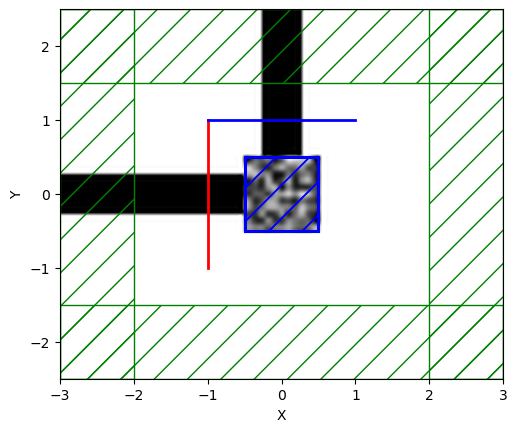

In [10]:
opt.plot2D(True)
plt.show()

In [11]:
f0, dJ_du = opt()

Starting forward run...
Starting adjoint run...
Calculating gradient...


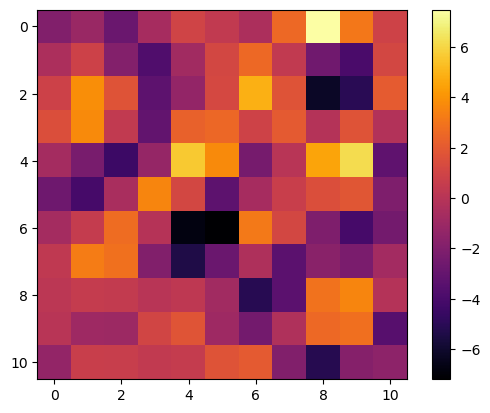

In [12]:
plt.figure()
plt.imshow(np.rot90(dJ_du.reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du), vmax=np.max(dJ_du))
plt.colorbar()
#plt.savefig("adjoint_gradient_map.png")

In [13]:
db = 1e-3
choose = 121
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

In [14]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du[idx], 1)

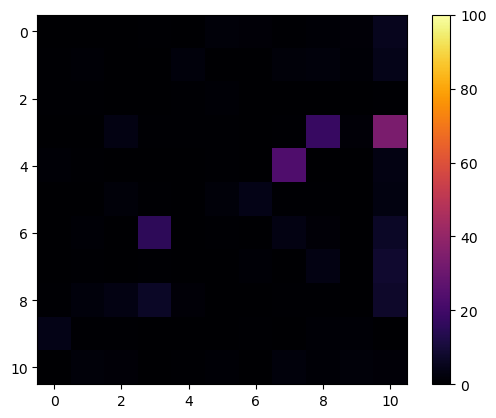

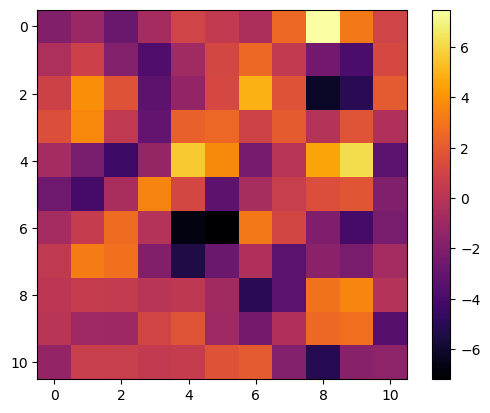

In [15]:
err= (np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100)
plt.imshow(np.rot90(err.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du), vmax=np.max(dJ_du))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

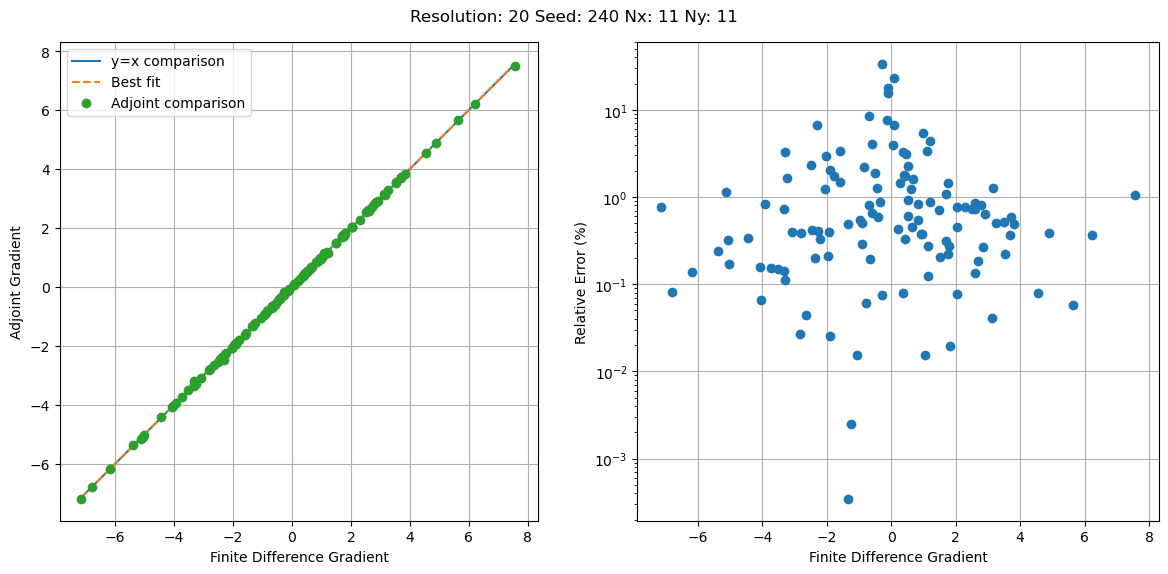

In [16]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}".format(resolution, seed, Nx, Ny))
plt.show()